<font size="+3"><strong>Earthquake Damage in Kavrepalanchok 🇳🇵</strong></font>

In [69]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Prepare Data

## Connect

In [13]:
%load_ext sql
%sql sqlite:////home/jovyan/nepal.sqlite

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


'Connected: @/home/jovyan/nepal.sqlite'

Get unique `district_id` from `id_map`

In [14]:
%%sql
SELECT DISTINCT(district_id)
FROM id_map


 * sqlite:////home/jovyan/nepal.sqlite
Done.


district_id
1
2
3
4


Count the number of observations in the `id_map` table associated with Kavrepalanchok.

In [40]:
%%sql
SELECT COUNT(*)
FROM id_map
WHERE district_id = 3

 * sqlite:////home/jovyan/nepal.sqlite
Done.


COUNT(*)
82684


In [22]:
%%sql
SELECT DISTINCT(I.building_id) AS b_id, B.*, D.damage_grade
FROM id_map AS I
JOIN building_structure AS B
ON I.building_id = B.building_id
JOIN building_damage AS D
ON B.building_id = D.building_id
WHERE district_id = 3
LIMIT 5

 * sqlite:////home/jovyan/nepal.sqlite
Done.


b_id,building_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,damage_grade
87473,87473,2,1,15,382,18,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 4
87479,87479,1,0,12,328,7,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Rubble clear,"Stone, mud mortar",Grade 5
87482,87482,2,1,23,427,20,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4
87491,87491,2,1,12,427,14,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4
87496,87496,2,0,32,360,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Rubble clear,"Stone, mud mortar",Grade 5


## Import

1. Create a `"severe_damage"` column, where all buildings with a damage grade greater than `3` are encoded as `1`. All other buildings are encoded at `0`. 
2. Drop any columns that could cause issues with leakage, multicollinearity or low/high cardinality in the model.

In [25]:
# Build your `wrangle` function here
def wrangle(data_path):
    conn = sqlite3.connect(data_path)
    query = """
        SELECT DISTINCT(I.building_id) AS b_id, B.*, D.damage_grade
        FROM id_map AS I
        JOIN building_structure AS B
        ON I.building_id = B.building_id
        JOIN building_damage AS D
        ON B.building_id = D.building_id
        WHERE district_id = 3
        """
    
    df = pd.read_sql(query, conn, index_col = 'b_id')
    
    # Create target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    df.drop(['damage_grade'], axis=1, inplace=True)
    
    # Drop leakage
    drop_cols = [col for col in df.columns if "post_eq" in col]
    df.drop(drop_cols, axis=1, inplace=True)
    
    # Drop multilinear columns
    df.drop(["count_floors_pre_eq"], axis=1, inplace=True)
    
    # Drop high cardinal columns
    df.drop(['building_id'], axis=1, inplace=True)
    
    return df

In [26]:
df = wrangle('/home/jovyan/nepal.sqlite')
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
87473,15,382,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87479,12,328,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar",1
87482,23,427,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87491,12,427,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87496,32,360,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1


## Explore

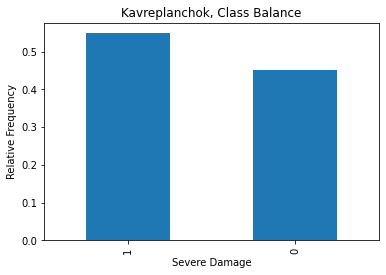

In [28]:
# Plot value counts of `"severe_damage"`
df['severe_damage'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Severe Damage')
plt.ylabel('Relative Frequency')
plt.title('Kavreplanchok, Class Balance')
# Don't delete the code below 👇
plt.savefig("images/4-5-6.png", dpi=150)


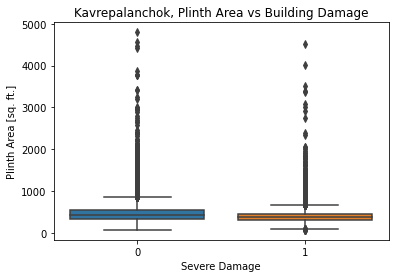

In [36]:
sns.boxplot(data = df, x='severe_damage', y='plinth_area_sq_ft')
plt.xlabel("Severe Damage")
plt.ylabel('Plinth Area [sq. ft.]')
plt.title('Kavrepalanchok, Plinth Area vs Building Damage')
# Don't delete the code below 👇
plt.savefig("images/4-5-7.png", dpi=150)


In [42]:
roof_pivot = pd.pivot_table(df, index='roof_type', values='severe_damage', aggfunc=np.mean)
roof_pivot

,severe_damage
roof_type,
Bamboo/Timber-Heavy roof,0.569477
Bamboo/Timber-Light roof,0.604842
RCC/RB/RBC,0.040715


## Split

In [44]:
target = 'severe_damage'
X = df.drop([target], axis=1)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (76533, 11)
y shape: (76533,)


In [50]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (61226, 11)
y_train shape: (61226,)
X_val shape: (15307, 11)
y_val shape: (15307,)


# Build Model

## Baseline

**Task 4.5.11:** Calculate the baseline accuracy score for your model.

In [54]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.55


## Iterate

### Logistic Regression

In [62]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
)
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [65]:
lr_train_acc = model_lr.score(X_train, y_train)
lr_val_acc = model_lr.score(X_val, y_val)

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

Logistic Regression, Training Accuracy Score: 0.6513735994512135
Logistic Regression, Validation Accuracy Score: 0.6530998889397008


### Decision Tree

In [73]:
depth_hyperparams = range(1, 16)
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    model_dt = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(random_state=42, max_depth = d)
    )
    model_dt.fit(X_train, y_train)
    training_acc.append(model_dt.score(X_train, y_train))
    validation_acc.append(model_dt.score(X_val, y_val))
    

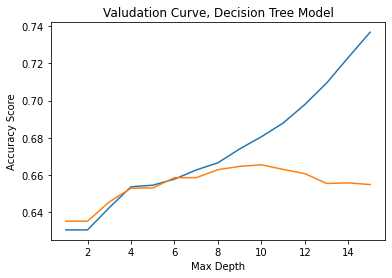

In [77]:
plt.plot(depth_hyperparams, training_acc, label='training accuracy')
plt.plot(depth_hyperparams, validation_acc, label='validation accuracy')
plt.xlabel('Max Depth')
plt.ylabel("Accuracy Score")
plt.title("Valudation Curve, Decision Tree Model")
# Don't delete the code below 👇
plt.savefig("images/4-5-15.png", dpi=150)


In [81]:
final_model_dt = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state=42, max_depth=10)
)
final_model_dt.fit(X_train, y_train)


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
Building with Central Courtyard     9
H-shape                            10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Stone, mud mortar        1
Adobe/mud                2
Brick, cement mortar     3
RC, engineered           4
Brick, mud mortar        5
Stone, cement mortar     6
RC, non-engineered       7
Timber                   8
Other                    9
Bamboo                  10
Stone                   11
NaN                     -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

## Evaluate

In [83]:
X_test = pd.read_csv("data/kavrepalanchok-test-features.csv", index_col="b_id")
y_test_pred = final_model_dt.predict(X_test)
y_test_pred[:5]

array([1, 1, 1, 1, 0])

# Communicate Results

In [88]:

feat_imp = pd.Series(final_model_dt.named_steps['decisiontreeclassifier'].feature_importances_, index=X_train.columns).sort_values()
feat_imp.head()

plan_configuration        0.004189
land_surface_condition    0.008599
foundation_type           0.009967
position                  0.011795
ground_floor_type         0.013521
dtype: float64

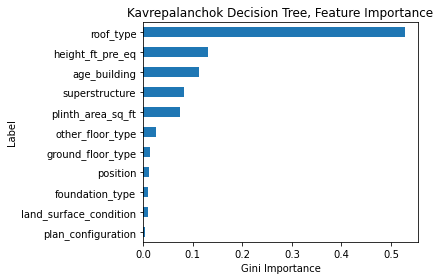

In [89]:
# Create horizontal bar chart of feature importances
feat_imp.plot(kind='barh', xlabel='Gini Importance', ylabel='Label', title='Kavrepalanchok Decision Tree, Feature Importance')
# Don't delete the code below 👇
plt.tight_layout()
plt.savefig("images/4-5-19.png", dpi=150)
